In [129]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Wedge
mpl.rcParams['text.usetex'] = False
import h5py
import numpy as np

import os
import sys

import torch

%config InlineBackend.figure_format = 'retina'

def plot_hist(f, fn):
    fig, axes = plt.subplots(1,3, figsize=(15, 3), sharey=False, sharex=False, tight_layout=False)
    fig.text(0.5, 1.01, f'{fn}', ha='center', fontsize=15)
    axes[0].hist(f['eta_mod'], bins=50, color='skyblue')
    axes[0].set_xlabel('eta_mod')
    axes[0].set_ylabel('Histogram')
    # plt.show()
    axes[1].hist(f['phi_mod'], bins=50, color='magenta')
    axes[1].set_xlabel('phi_mod')
    axes[1].set_ylabel('Histogram')
    # plt.show()
    axes[2].hist(np.log2(f['incident_energy']), density=False, log=True, bins=np.arange(8, 24, 0.5))
    axes[2].set_xlabel('log_2(E)')
    axes[2].set_ylabel('Histogram')
    plt.show()

In [130]:
directory = "/raid/javier/Datasets/CaloVAE/data/ATLAS_2/atlas_regular/"
filenames = os.listdir(directory)
filenames.sort()
print(filenames)
directory + filenames[1]

['dataset_eta_020_positive.hdf5', 'dataset_eta_025_positive.hdf5', 'dataset_eta_025_positive_cat.hdf5', 'dataset_eta_030_positive.hdf5', 'dataset_eta_035_positive.hdf5', 'dataset_eta_040_positive.hdf5', 'dataset_eta_045_positive.hdf5', 'dataset_eta_050_positive.hdf5', 'dataset_eta_055_positive.hdf5', 'dataset_eta_060_positive.hdf5', 'dataset_eta_065_positive.hdf5', 'dataset_eta_070_positive.hdf5', 'dataset_eta_085_positive.hdf5', 'dataset_eta_090_positive.hdf5', 'dataset_eta_095_positive.hdf5']


'/raid/javier/Datasets/CaloVAE/data/ATLAS_2/atlas_regular/dataset_eta_025_positive.hdf5'

dataset_eta_025_positive.hdf5
torch.Size([127271, 336])


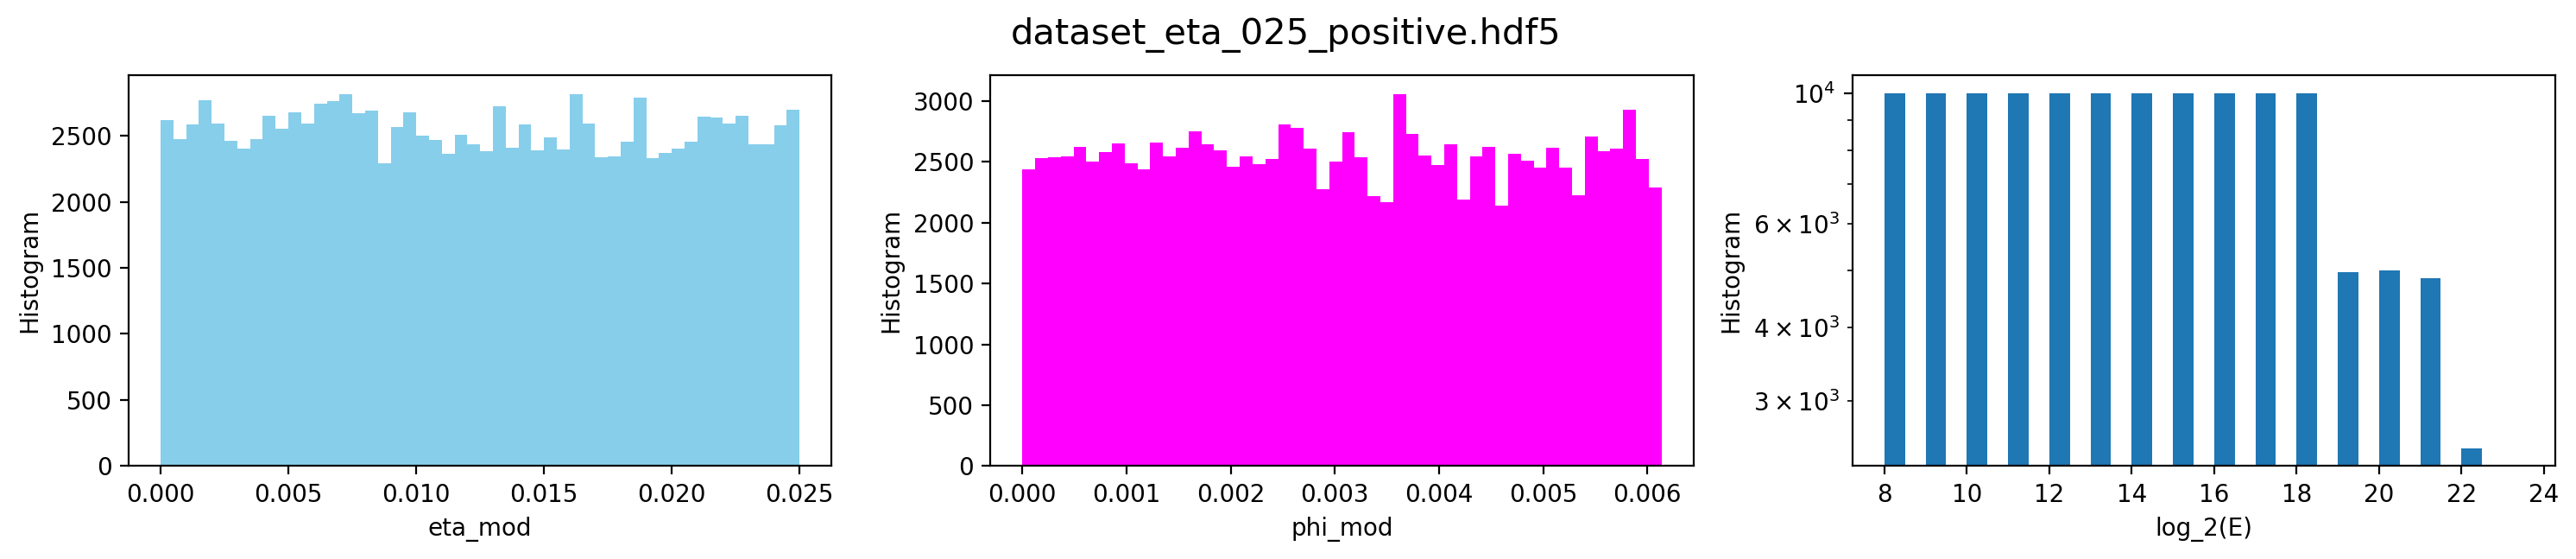

In [131]:


# ATLAS_raw_dir = '/raid/javier/Datasets/CaloVAE/data/ATLAS/dataset_eta_020_positive.hdf5'
# for fn in filenames:
fn = filenames[1]
print(fn)
ATLAS_raw_dir = directory + fn #filenames[-2]
with h5py.File(ATLAS_raw_dir, 'r') as file:
    # List all groups
    f = {}
    # print("Keys: %s" % list(file.keys()))
    for key in file.keys():
        f[key] = torch.tensor(np.array(file[key]))
print(f["energy_layer_1"].shape)
plot_hist(f,fn)


In [31]:
# list(f.keys())
print(f["incident_energy"].min().log())
print(f["incident_energy"].max().log())

tensor(5.5452, dtype=torch.float64)
tensor(15.2492, dtype=torch.float64)


In [22]:
# torch.cat([f[f'energy_layer_{i}'] for i in [0,1,2,3,12,13,14]], dim=1)
f["incident_energy"].unsqueeze(1).shape

torch.Size([127271, 1])

In [23]:

import h5py

# Convert tensors to numpy arrays as h5py does not support PyTorch tensors directly
tensor1_np = torch.cat([f[f'energy_layer_{i}'] for i in [0,1,2,3,12,13,14]], dim=1).numpy()
tensor2_np = f["incident_energy"].unsqueeze(1).numpy()

# Create a new HDF5 file
with h5py.File(f'/raid/javier/Datasets/CaloVAE/data/ATLAS_2/atlas_regular/dataset_eta_025_positive_cat.hdf5', 'w') as f:
    # Create datasets for your tensors
    f.create_dataset('showers', data=tensor1_np)
    f.create_dataset('incident_energies', data=tensor2_np)

In [73]:
# np.unique(f[f'binstart_radius_layer_0'])
s = 0
for i in range(4):
    print(f[f'binstart_radius_layer_{i}'].shape)
    s = s + f[f'binstart_radius_layer_{i}'].shape[0]
print(s)

s = 0
for i in [0,1,2,3,12,13]:
    print(f[f'binstart_radius_layer_{i}'].shape)
    s = s + f[f'binstart_radius_layer_{i}'].shape[0]
print(s)

torch.Size([336])
torch.Size([336])
torch.Size([336])
torch.Size([336])
1344
torch.Size([336])
torch.Size([336])
torch.Size([336])
torch.Size([336])
torch.Size([336])
torch.Size([336])
2016


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def add_cylindrical_voxel(ax, r_in, r_out, theta0, theta1, z_low, z_high, num_points=20, color=None):
    """
    Adds a single cylindrical voxel (wedge) to the 3D axis.
    
    Parameters:
      ax       : Matplotlib 3D axis.
      r_in     : Inner radius.
      r_out    : Outer radius.
      theta0   : Starting angle in radians.
      theta1   : Ending angle in radians.
      z_low    : Lower z-bound.
      z_high   : Upper z-bound.
      num_points: Number of points along the arc.
      color    : Color to fill the voxel.
    """
    # Generate a smooth arc between theta0 and theta1.
    theta = np.linspace(theta0, theta1, num_points)
    
    # Top face arcs
    outer_top = np.column_stack((r_out * np.cos(theta), r_out * np.sin(theta), np.full(theta.shape, z_high)))
    inner_top = np.column_stack((r_in * np.cos(theta), r_in * np.sin(theta), np.full(theta.shape, z_high)))
    
    # Bottom face arcs
    outer_bot = np.column_stack((r_out * np.cos(theta), r_out * np.sin(theta), np.full(theta.shape, z_low)))
    inner_bot = np.column_stack((r_in * np.cos(theta), r_in * np.sin(theta), np.full(theta.shape, z_low)))
    
    # Build top and bottom faces (by joining outer and inner arcs)
    top_face = np.concatenate((outer_top, inner_top[::-1]))
    bottom_face = np.concatenate((outer_bot, inner_bot[::-1]))
    
    # Create side faces at the angular boundaries (using first and last points)
    side_face_start = np.array([outer_bot[0], outer_top[0], inner_top[0], inner_bot[0]])
    side_face_end   = np.array([outer_bot[-1], outer_top[-1], inner_top[-1], inner_bot[-1]])
    
    faces = [top_face, bottom_face, side_face_start, side_face_end]
    
    poly3d = Poly3DCollection(faces, alpha=0.6, edgecolor='k', facecolor=color)
    ax.add_collection3d(poly3d)

def add_layer_varying(ax, radii, thetas, z_low, z_high, num_points=20, color=None):
    """
    Constructs one layer of the cylinder when the angular partitions vary by ring.
    
    The radii and theta arrays are 1D with repeated values. We group them
    and, for each annular cell between unique radii[i] and unique radii[i+1],
    we use the theta boundaries from the outer ring (group i+1). This function
    also adds a closing wedge to complete the circle.
    
    Parameters:
      ax     : The matplotlib 3D axis.
      radii  : 1D array of radii boundaries (with repeats).
      thetas : 1D array of theta boundaries (with repeats).
      z_low  : Lower z-bound for this layer.
      z_high : Upper z-bound for this layer.
      color  : Color for this layer.
    """
    unique_radii, r_counts = np.unique(radii, return_counts=True)
    
    # Split the theta array into groups using the counts from radii.
    theta_groups = []
    idx = 0
    for count in r_counts:
        theta_groups.append(thetas[idx:idx+count])
        idx += count

    # Loop over annular cells.
    for i in range(len(unique_radii) - 1):
        r_in = unique_radii[i]
        r_out = unique_radii[i+1]
        # Choose theta boundaries from the outer ring (group i+1).
        if i+1 < len(theta_groups):
            theta_boundaries = theta_groups[i+1]
        else:
            theta_boundaries = theta_groups[-1]
            
        # Create wedges for each angular segment.
        for j in range(len(theta_boundaries) - 1):
            theta0 = theta_boundaries[j]
            theta1 = theta_boundaries[j+1]
            add_cylindrical_voxel(ax, r_in, r_out, theta0, theta1, z_low, z_high, num_points, color)
        
        # --- Add the closing wedge ---
        theta0 = theta_boundaries[-1]
        theta1 = theta_boundaries[0] + 2 * np.pi
        add_cylindrical_voxel(ax, r_in, r_out, theta0, theta1, z_low, z_high, num_points, color)


/tmp/ipykernel_3364274/3054673983.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("viridis")


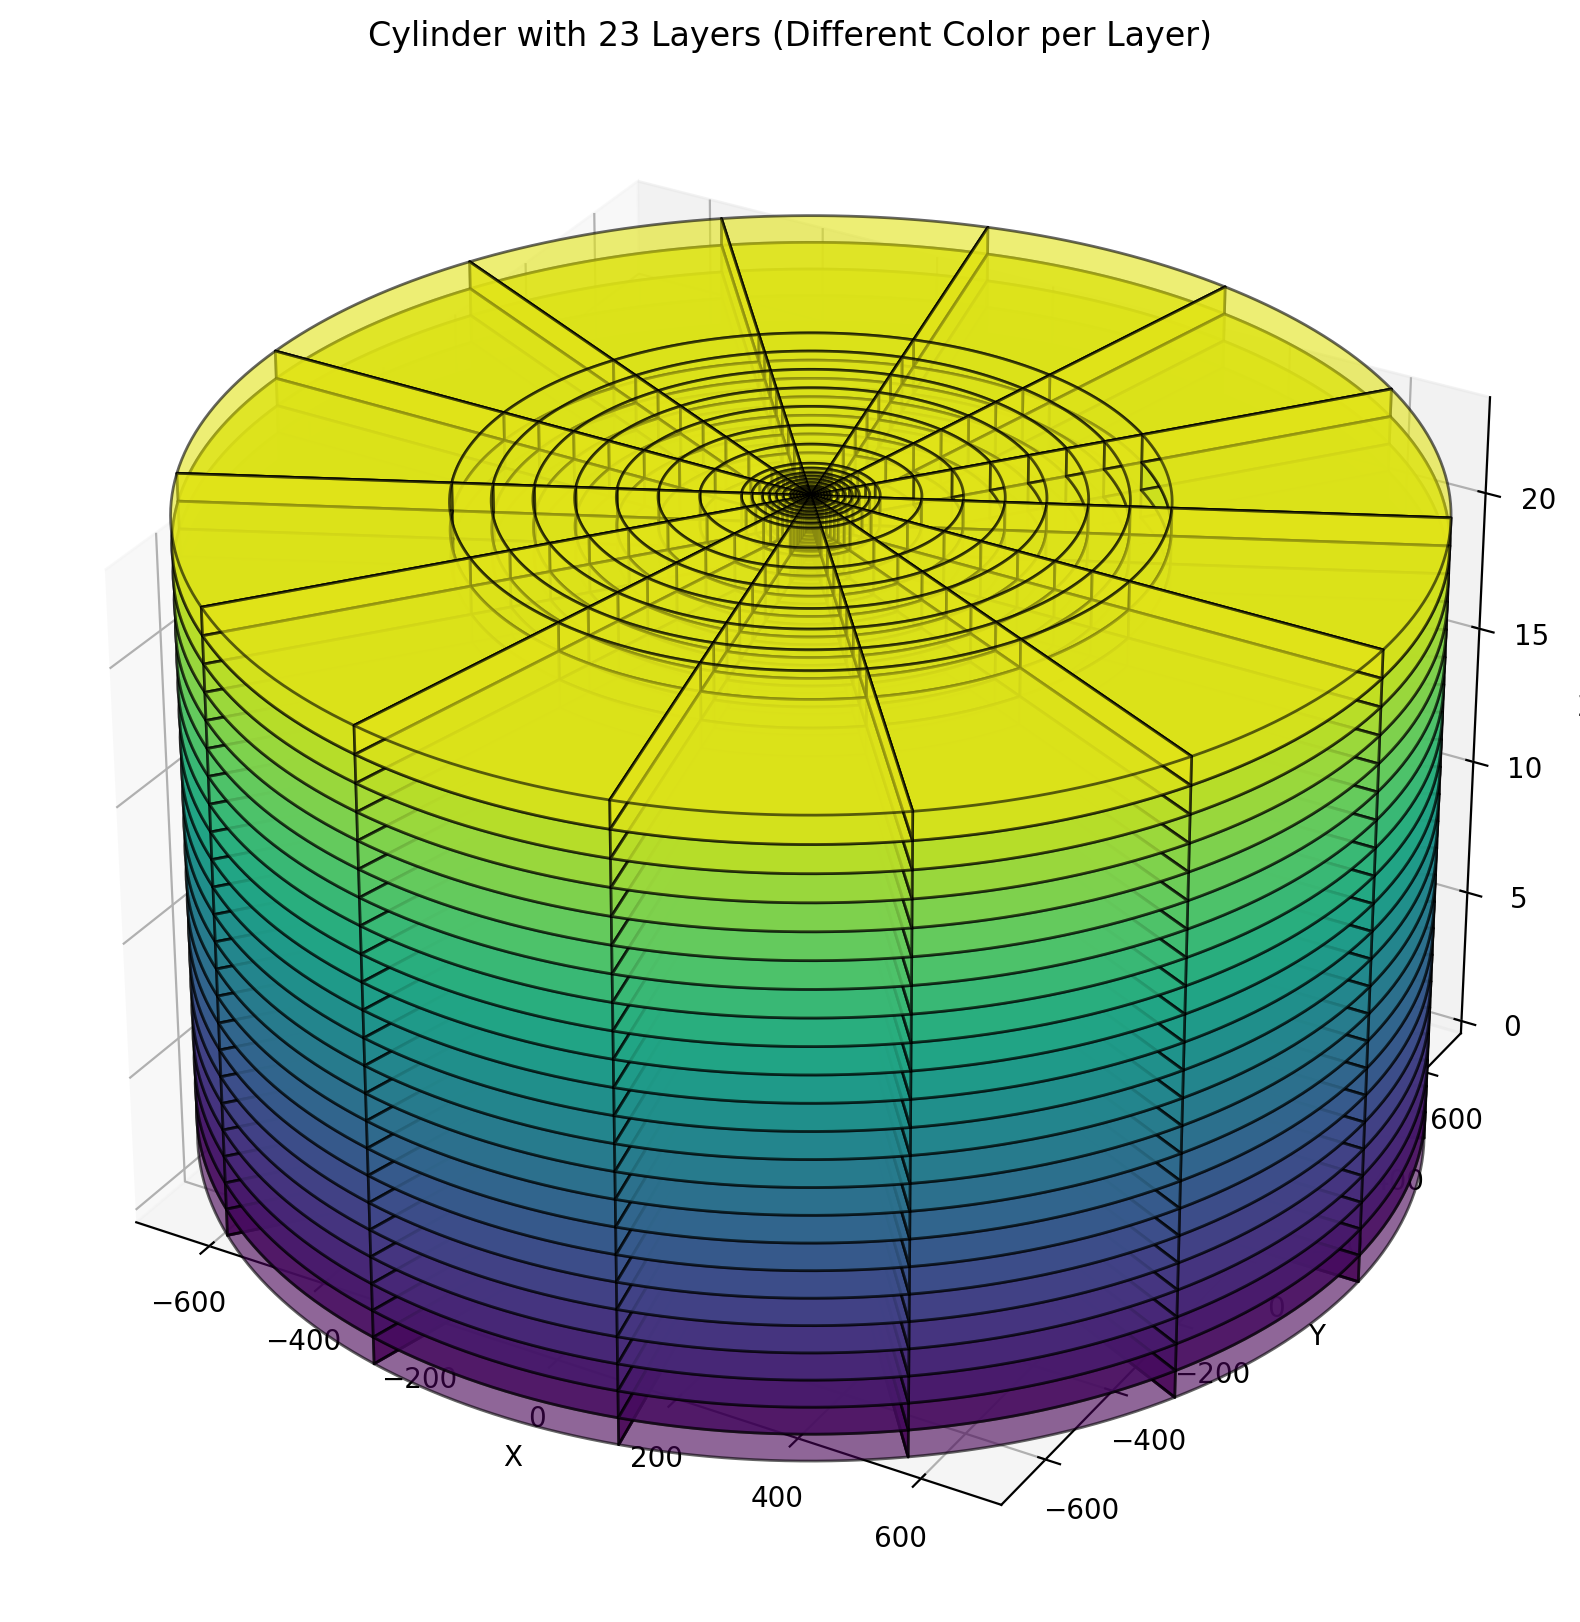

In [59]:
# --- Example usage ---
# For this example, we assume the theta array is complete and each group’s length matches 
# the repetition count for the corresponding unique radius in the radii array.
# (In your actual data you might need to verify or adjust the grouping.)

# Set up the 3D plot.
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

num_layers = 23
layer_thickness = 1.0  # Adjust vertical spacing as needed

colormap = cm.get_cmap("viridis")

for layer in range(num_layers):
    z_low = layer * layer_thickness
    z_high = (layer + 1) * layer_thickness
    # Get a color from the colormap based on the layer index.
    color = colormap(layer / num_layers)
    add_layer_varying(ax, f[f'binstart_radius_layer_{layer}'], f[f'binstart_alpha_layer_{layer}'], z_low, z_high, num_points=20, color=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-700, 700)
ax.set_ylim(-700, 700)
ax.set_zlim(0, num_layers * layer_thickness)
plt.title("Cylinder with 23 Layers (Different Color per Layer)")
plt.show()

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

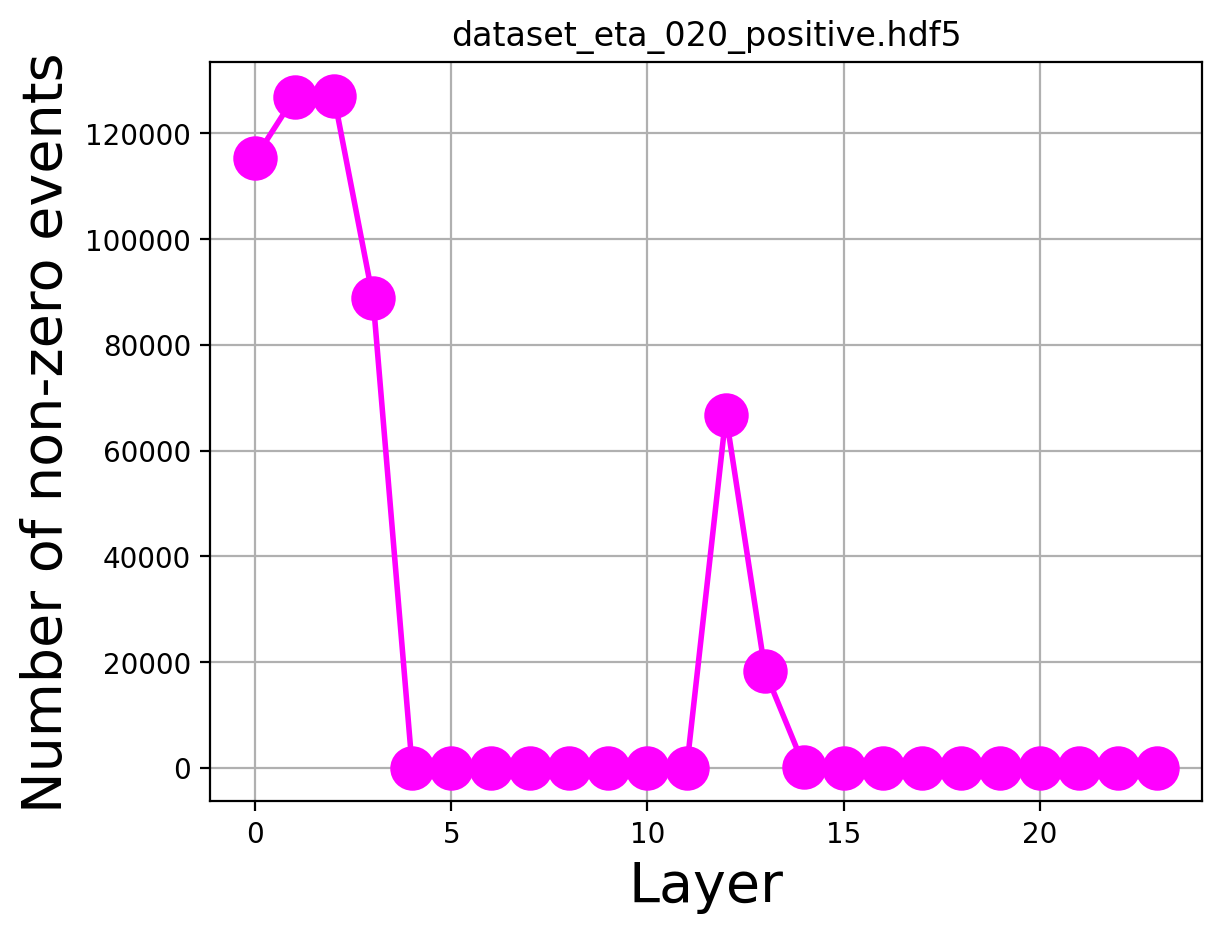

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

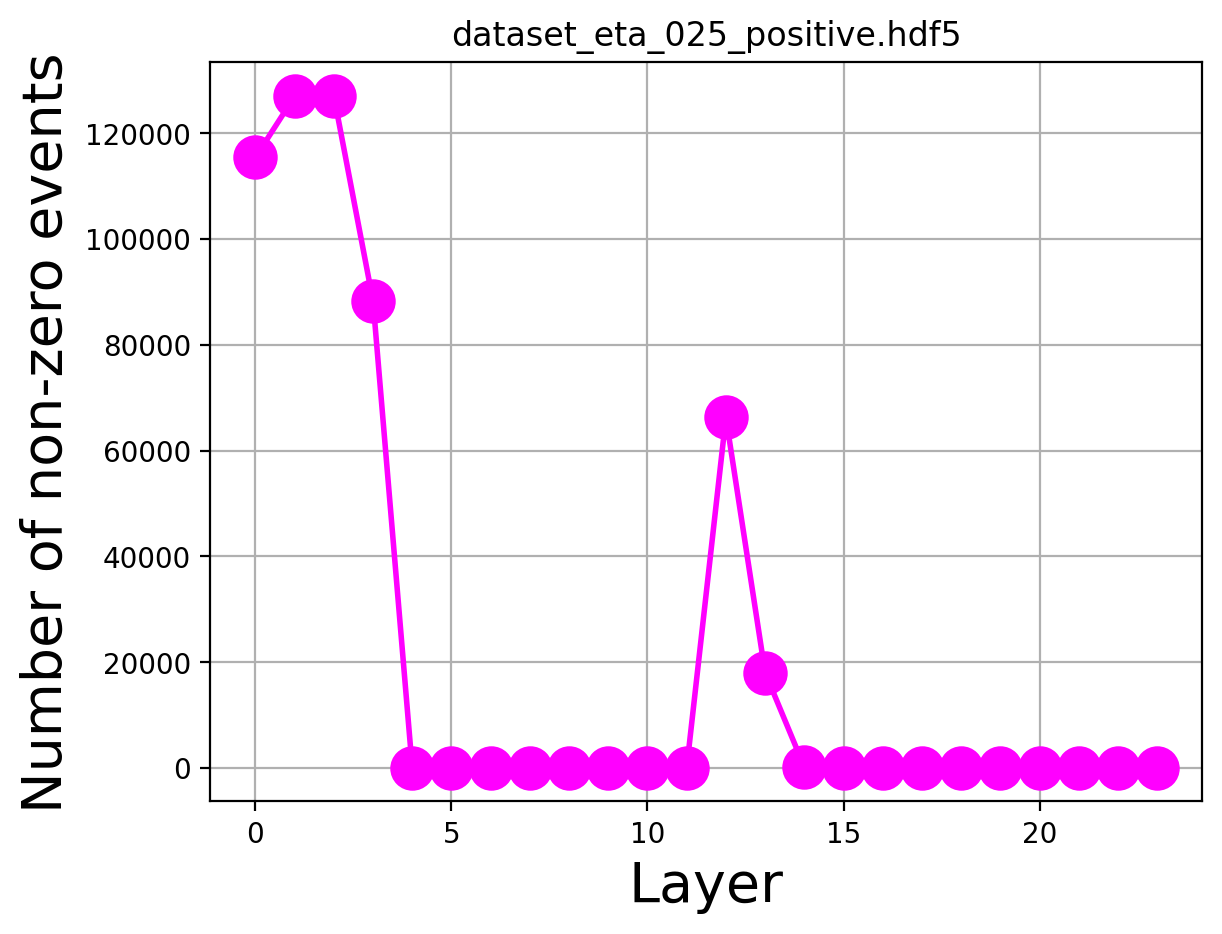

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

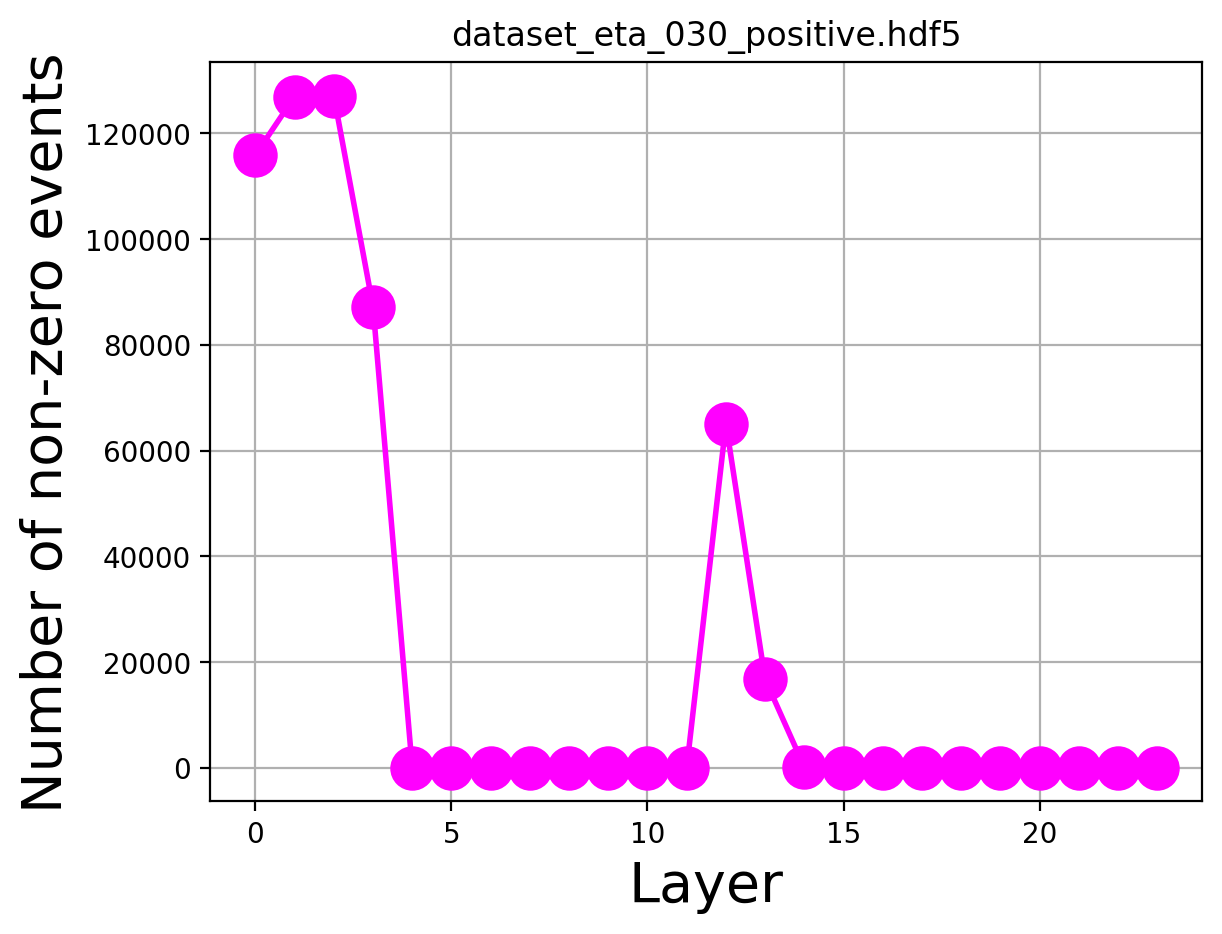

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

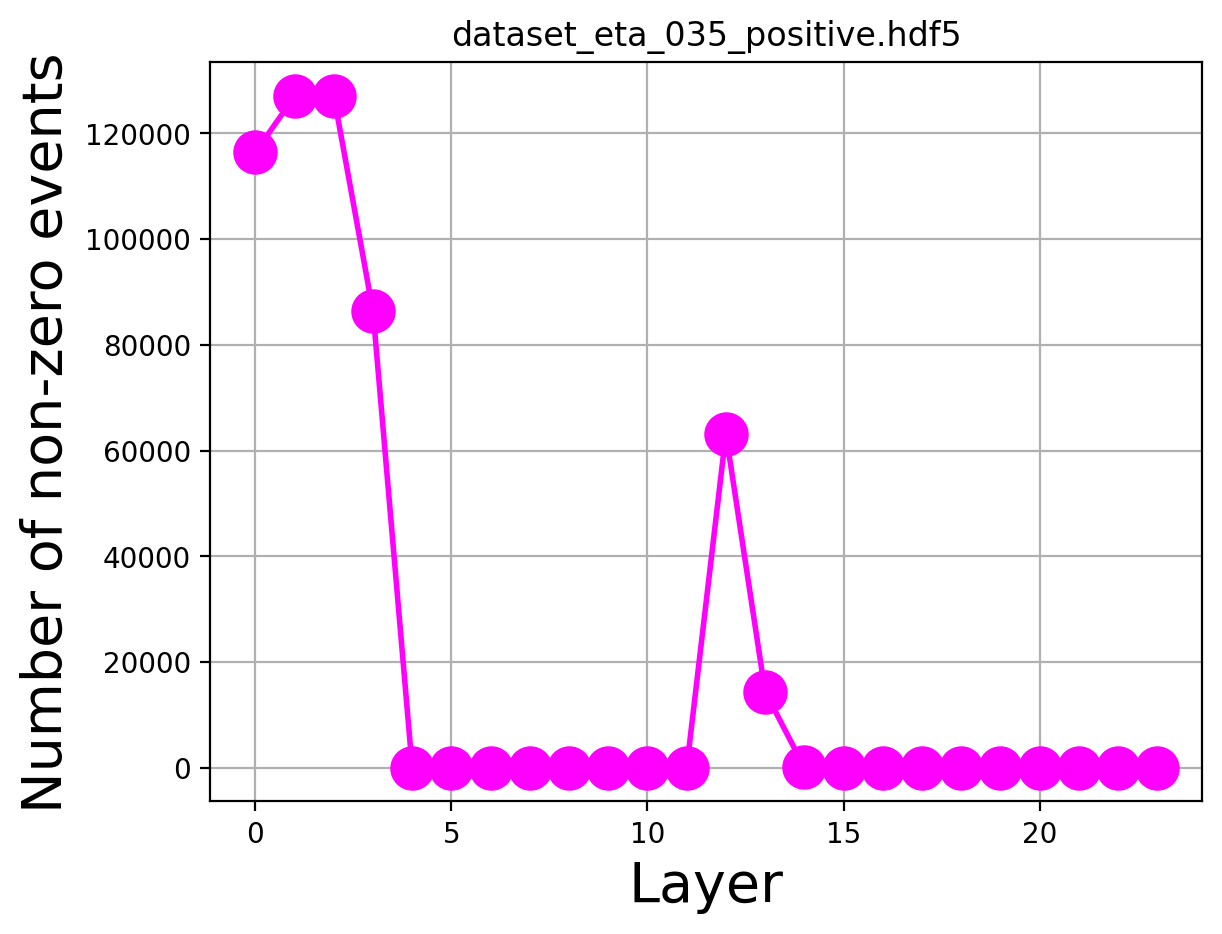

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

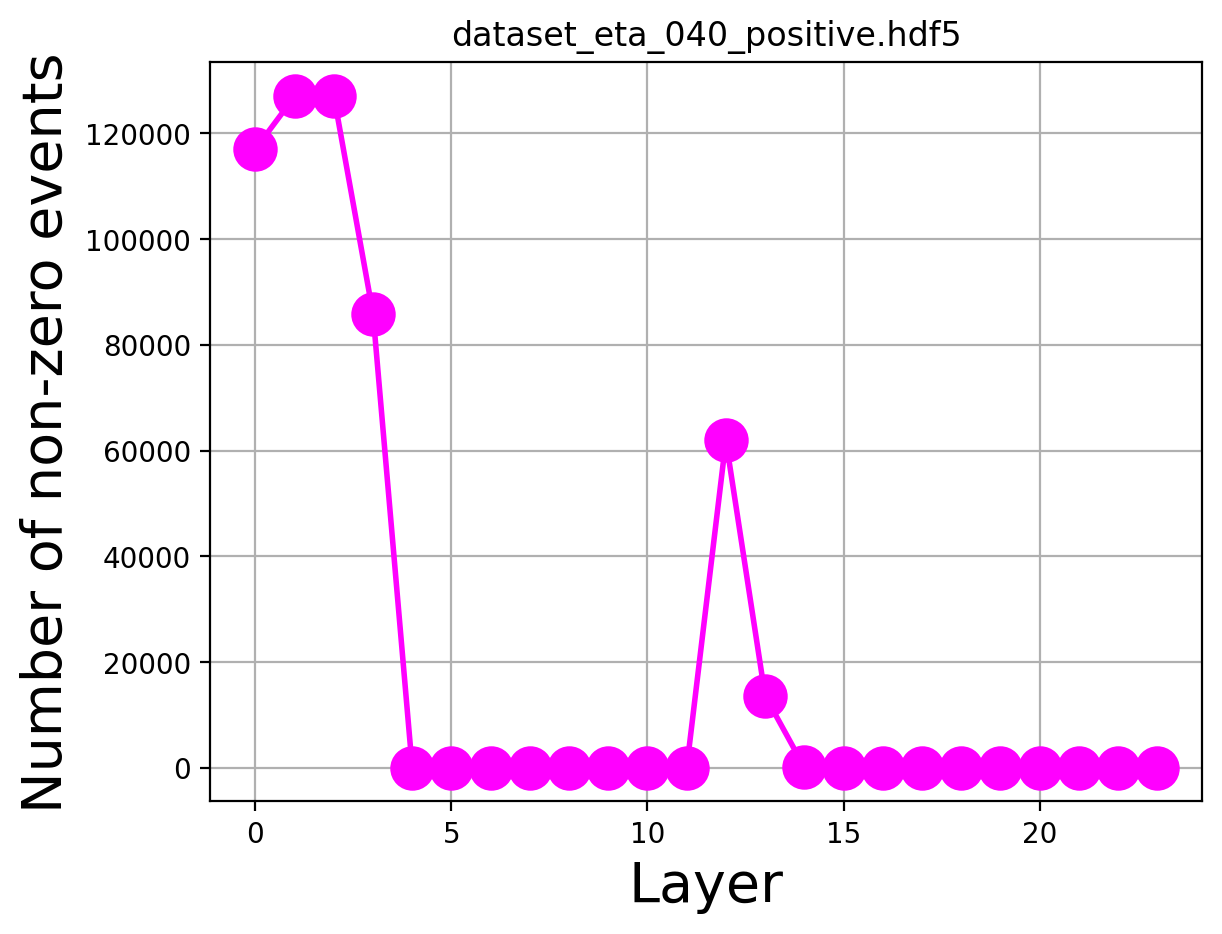

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

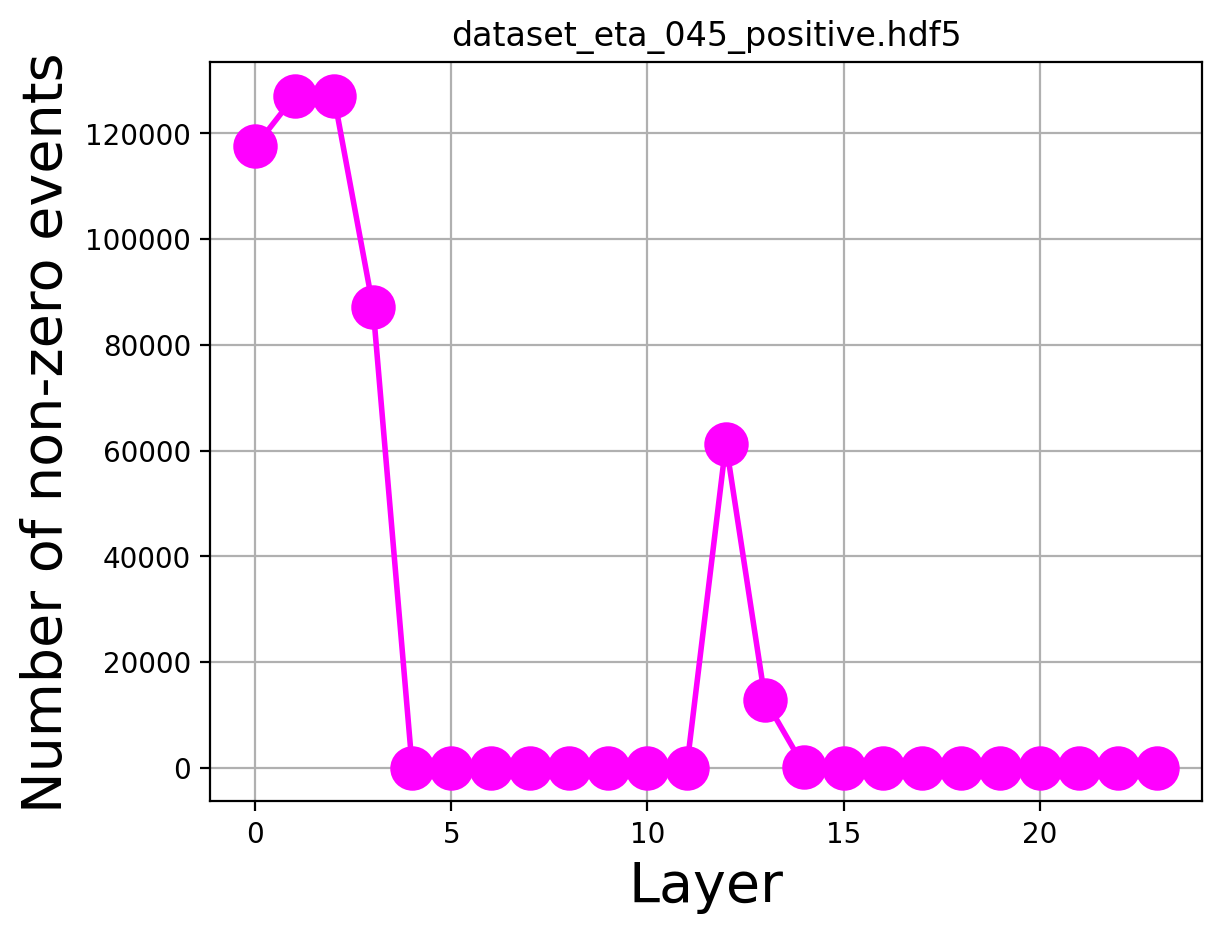

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

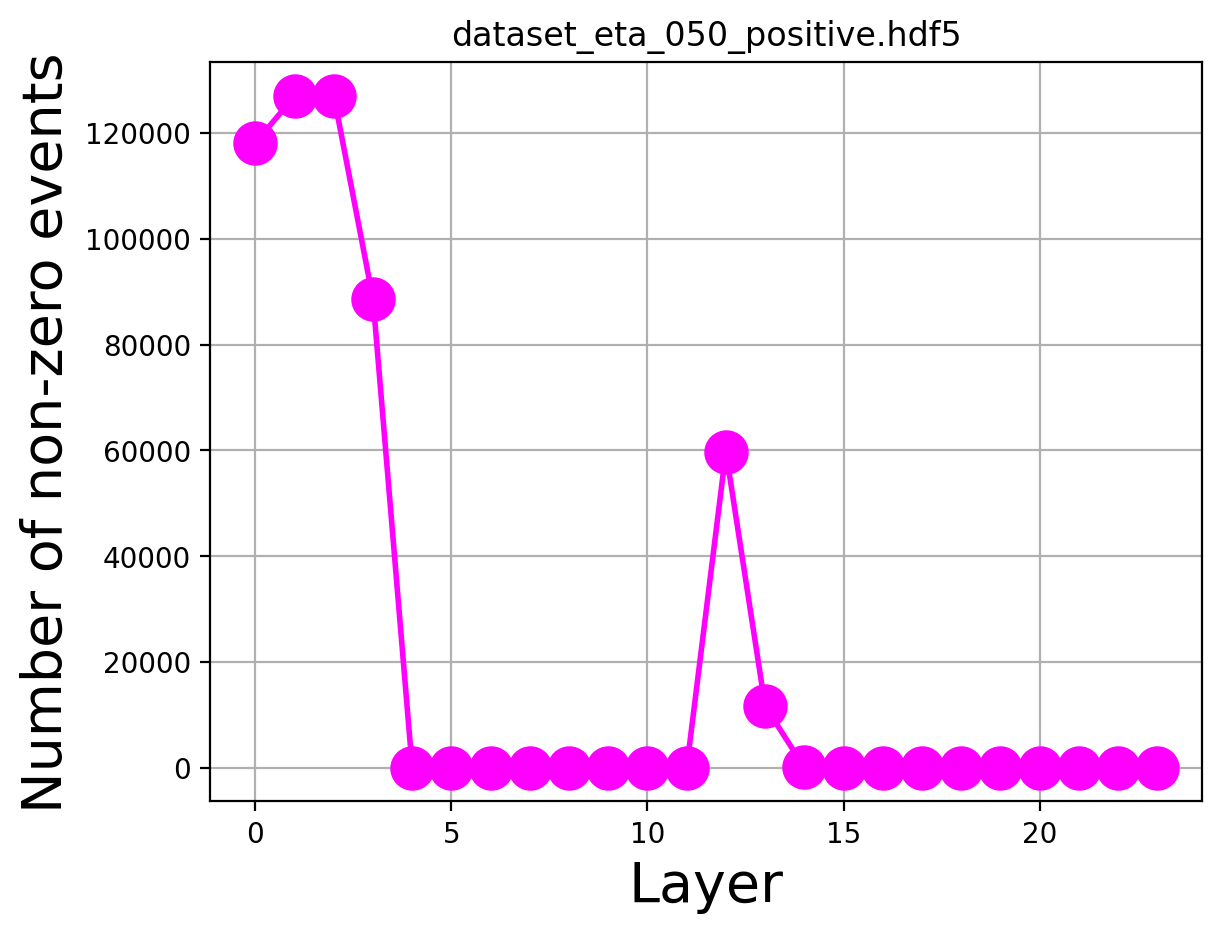

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

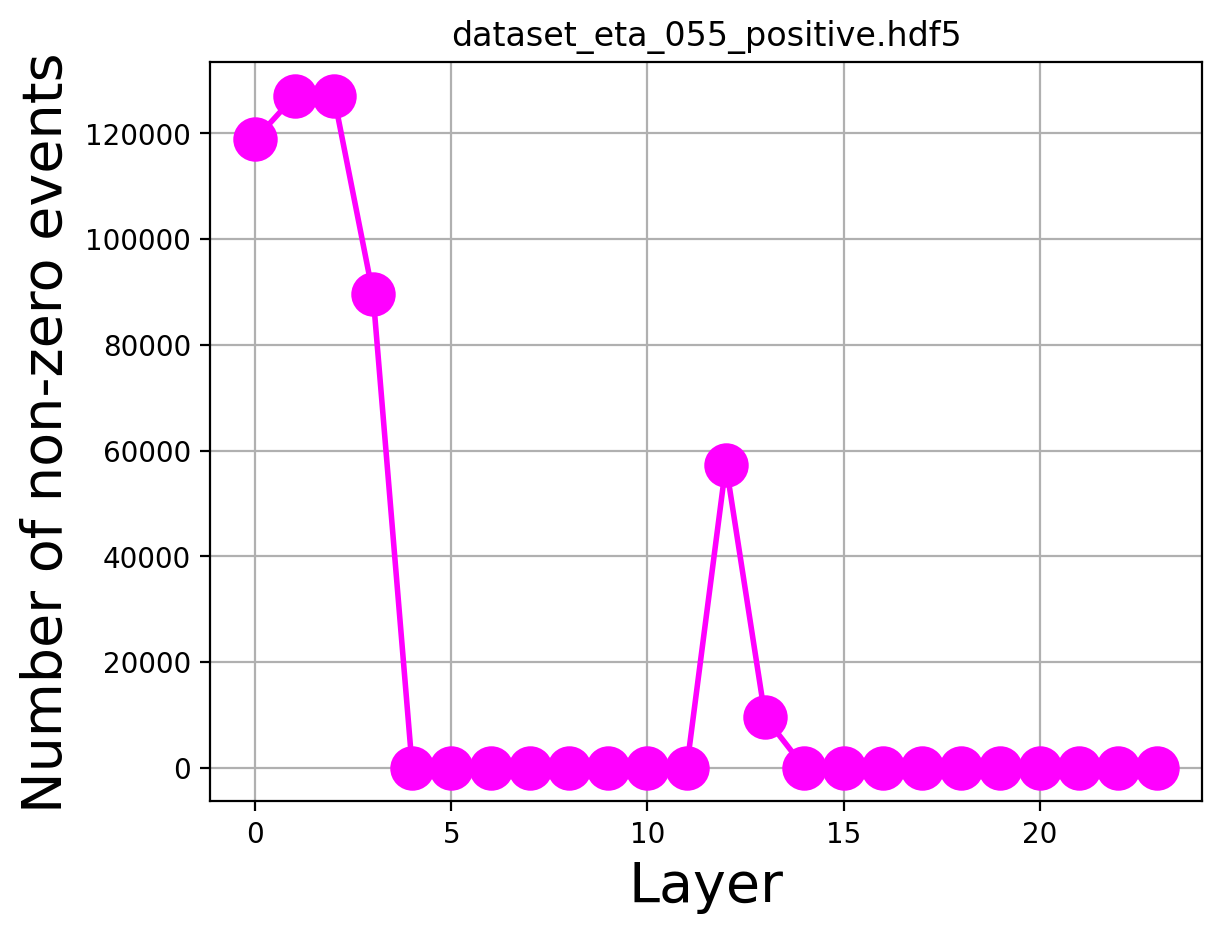

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

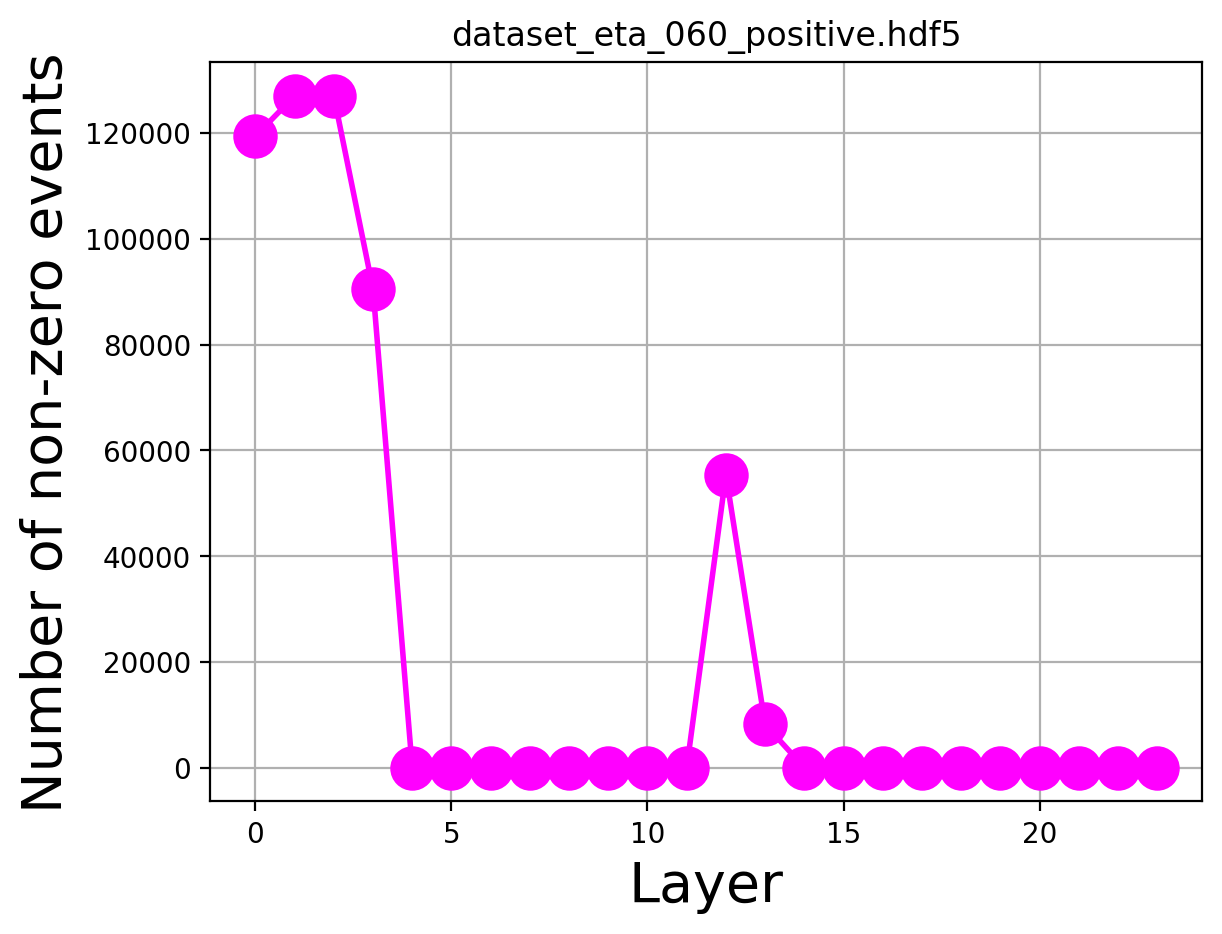

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

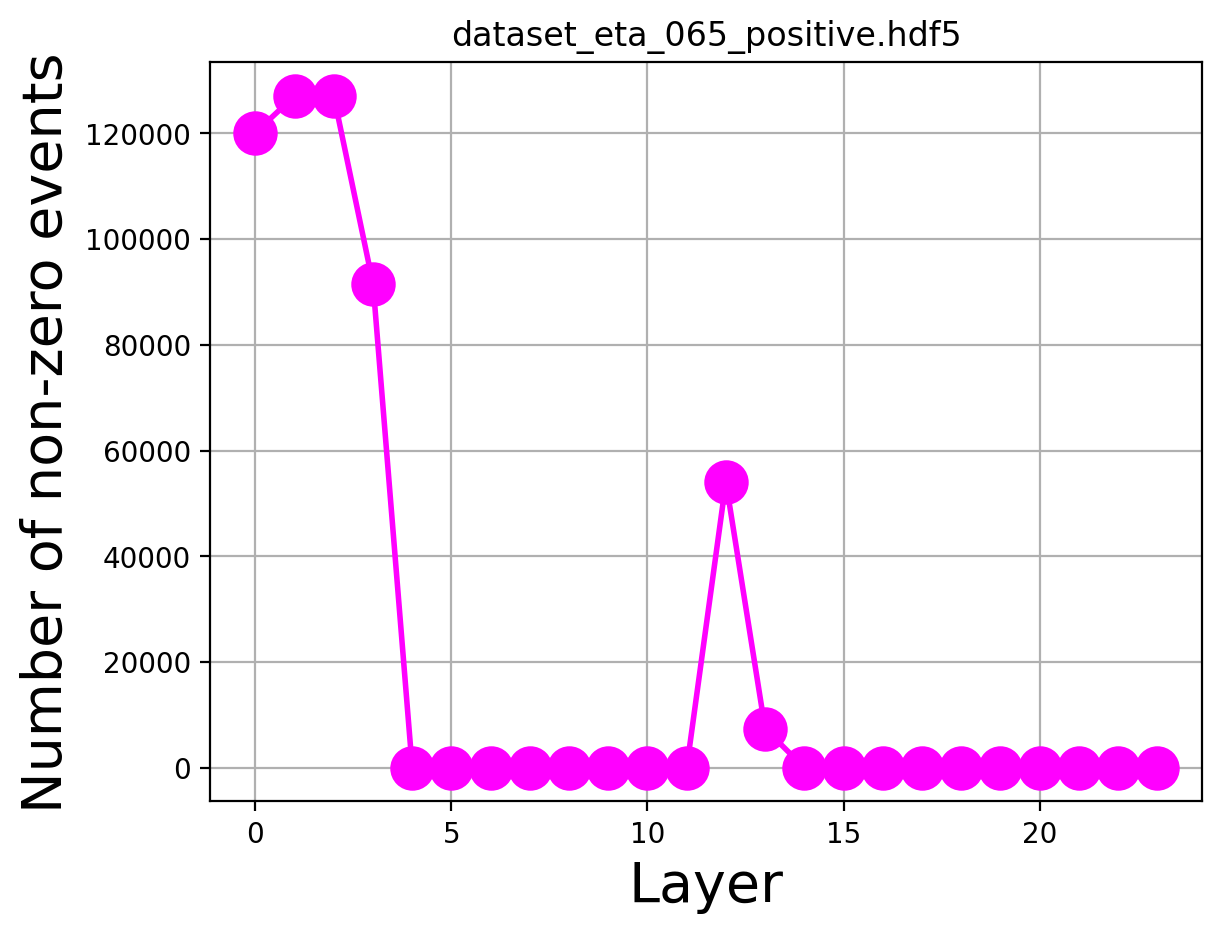

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

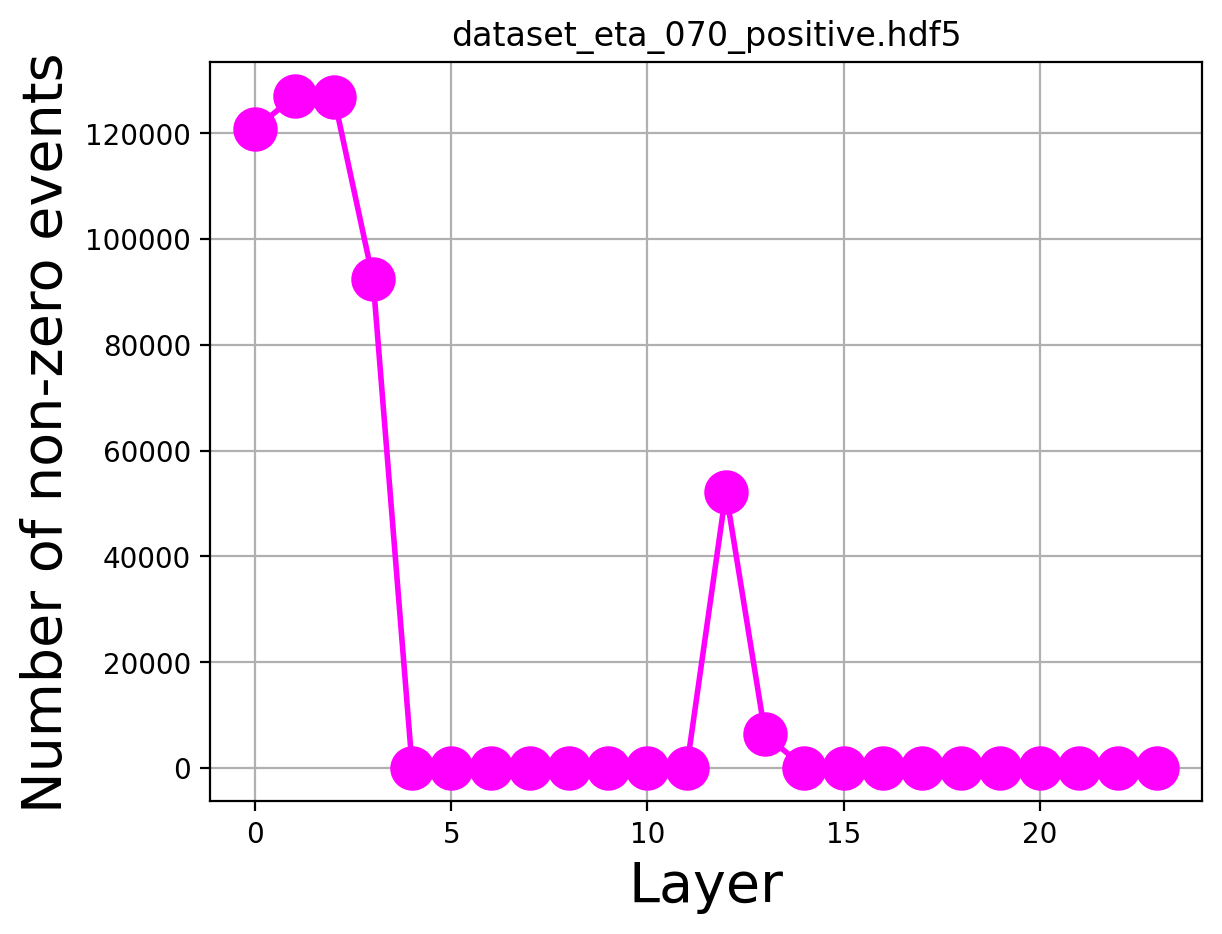

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

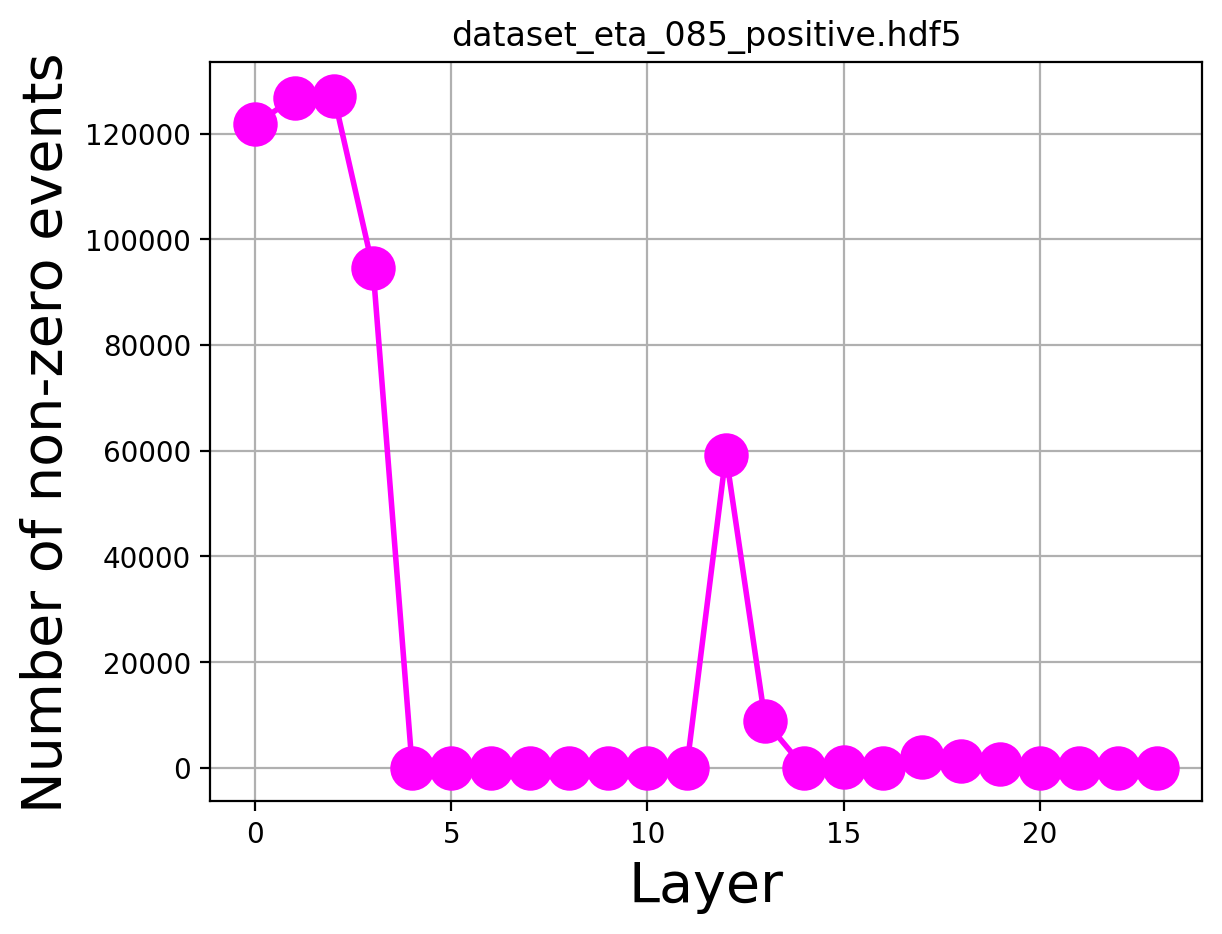

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

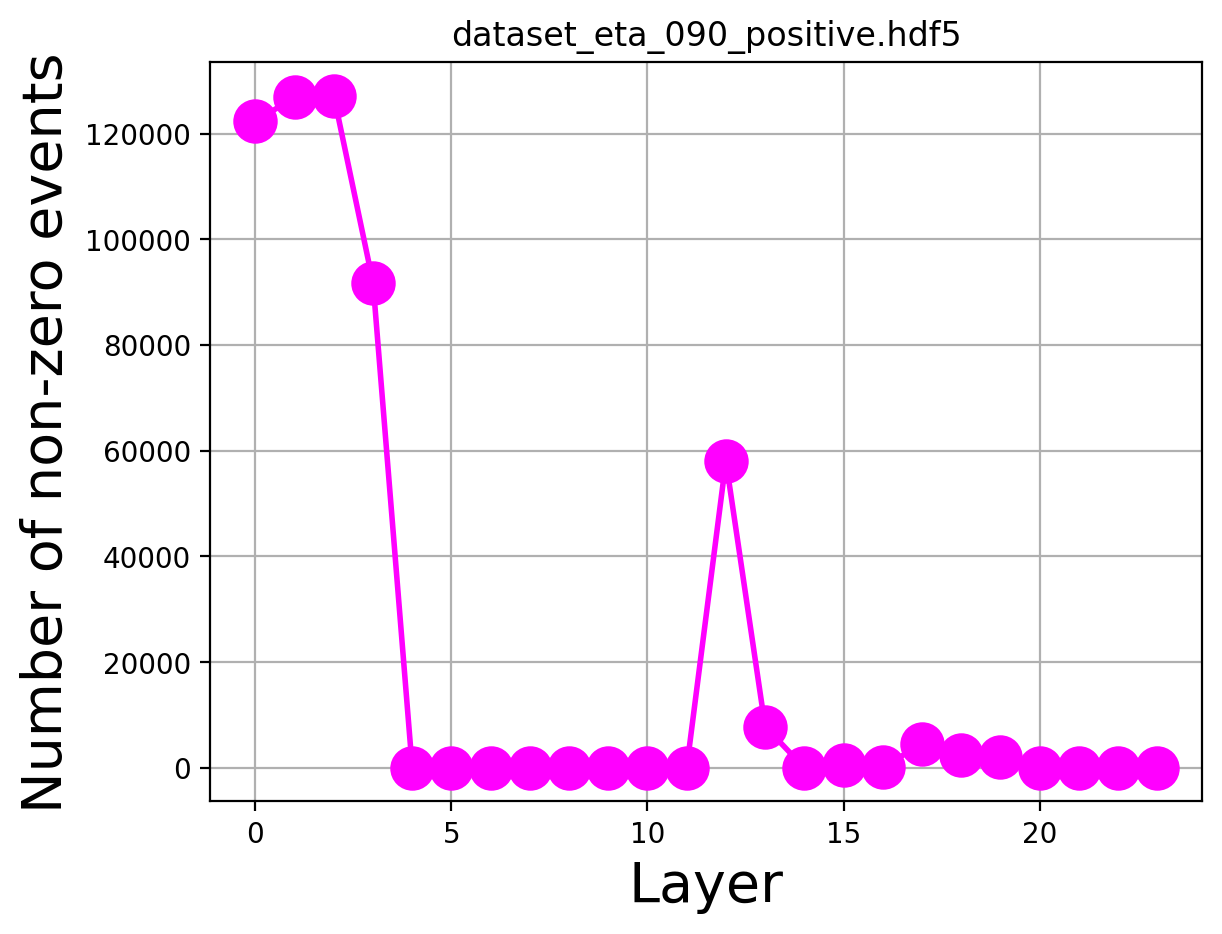

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

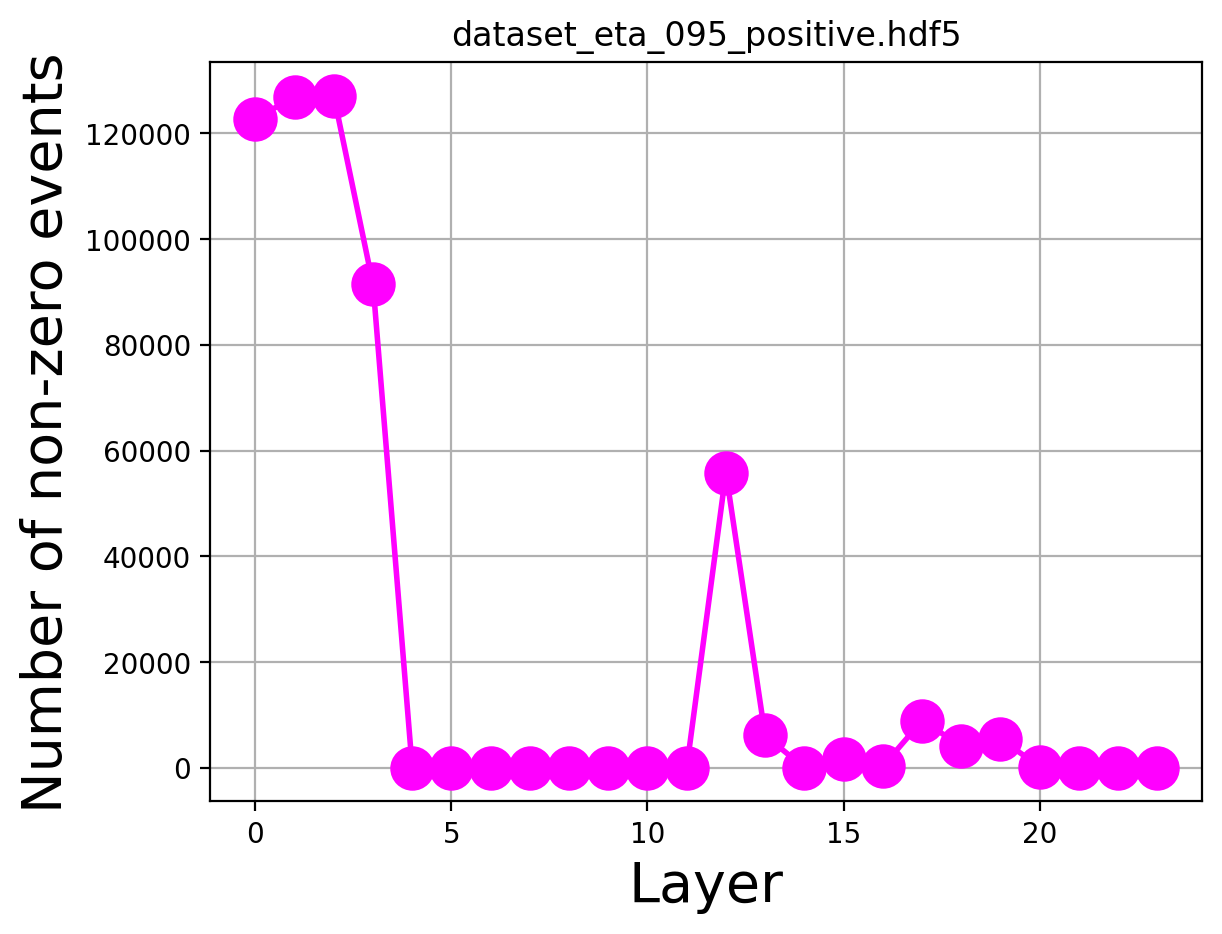

In [69]:
for fn in filenames:
    # print(fn)
    ATLAS_raw_dir = directory + fn #filenames[-2]
    plot_atlas = PLT_ATLAS(ATLAS_raw_dir,125000)
    plt.plot([plot_atlas.data[f'energy_layer_{i}'].sum(dim=1).nonzero().shape[0] for i in range(24)], lw=2, color="magenta", marker="o", markersize=15)
    plt.grid(True)
    plt.xlabel("Layer", fontsize=20)
    plt.ylabel("Number of non-zero events", fontsize=20)
    plt.title(f'{fn}')
    plt.show()




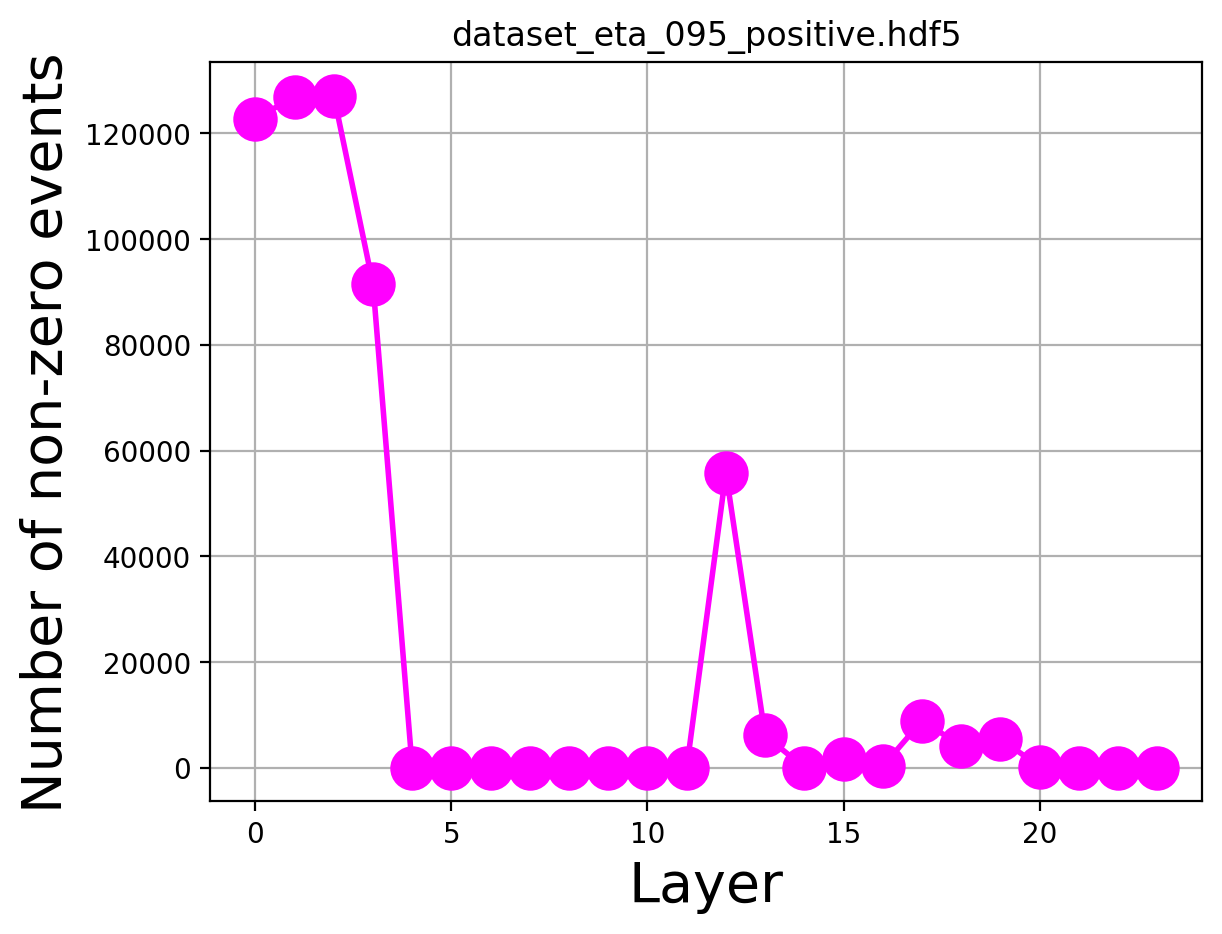

In [67]:
plt.plot([plot_atlas.data[f'energy_layer_{i}'].sum(dim=1).nonzero().shape[0] for i in range(24)], lw=2, color="magenta", marker="o", markersize=15)
plt.grid(True)
plt.xlabel("Layer", fontsize=20)
plt.ylabel("Number of non-zero events", fontsize=20)
plt.title(f'{fn}')
plt.show()

In [132]:
import numpy as np
import torch
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

class HighLevelFeatures_ATLAS_regular:
    def __init__(self, particle, filename, relevantLayers=[0,1,2,3,12,13,14], wandb = True):
        """
        Initialize the PLT_ATLAS object.

        Parameters:
        - filename: Path to the raw HDF5 data file.
        - event_n: Event number to process.
        - relevantLayers: List of layer numbers to plot. Defaults to [0, 1, 2, 3, 12].
        """
        self.wandb = wandb
        self.relevantLayers = relevantLayers
        self.ATLAS_raw_dir = filename
        # self.data = h5py.File(self.ATLAS_raw_dir, 'r')
        self.bin_info()
        
    def bin_info(self):
        with h5py.File(self.ATLAS_raw_dir, 'r') as file:
            # List all groups
            # self.data = {}
            self.binsize_alpha = {}
            self.binstart_alpha = {}
            self.binsize_radius = {}
            self.binstart_radius = {}
            print("Keys: %s" % list(file.keys()))
            for key in file.keys():
                # self.data[key] = torch.tensor(np.array(file[key]))
                if "binsize_alpha_layer_" in key:
                    layer = key.split("_")[-1]
                    self.binsize_alpha[layer] = torch.tensor(np.array(file[key])) # self.data[f"binsize_alpha_layer_{layer}"]
                if "binstart_alpha_layer_" in key:
                    layer = key.split("_")[-1]
                    self.binstart_alpha[layer] = torch.tensor(np.array(file[key])) #self.data[f"binstart_alpha_layer_{layer}"]
                if "binsize_radius_layer_" in key:
                    layer = key.split("_")[-1]
                    self.binsize_radius[layer] = torch.tensor(np.array(file[key])) #self.data[f"binsize_radius_layer_{layer}"]
                if "binstart_radius_layer_" in key:
                    layer = key.split("_")[-1]
                    self.binstart_radius[layer] = torch.tensor(np.array(file[key])) #self.data[f"binstart_radius_layer_{layer}"]

    def get_sector_arrays(self, layer):
        # All in torch, then to numpy once
        r0 = self.binstart_radius[layer]
        r1 = r0 + self.binsize_radius[layer]
        a0 = torch.rad2deg(self.binstart_alpha[layer]).round()
        a1 = a0 + torch.rad2deg(self.binsize_alpha[layer]).round()
        e  = self.single_event_energy

        # Convert once
        return (
            r0.cpu().numpy(),
            r1.cpu().numpy(),
            a0.cpu().numpy(),
            a1.cpu().numpy(),
            e .cpu().numpy()
        )

    def _make_equal_bin_transform(self, r0, r1):
        # Build sorted unique boundaries
        bounds = np.unique(np.concatenate([r0, r1]))
        N = len(bounds) - 1
        plot_bounds = np.linspace(0, 1, N+1)

        # For any radius array R, get indices of lower boundary
        def transform(R):
            idx = np.searchsorted(bounds, R, side="right") - 1
            # clip to valid range
            idx = np.clip(idx, 0, N-1)
            # fraction within each bin
            frac = (R - bounds[idx]) / (bounds[idx+1] - bounds[idx])
            return plot_bounds[idx] + frac*(plot_bounds[idx+1] - plot_bounds[idx])

        return transform

    def plot_calorimeter(self, ax, scale='equal_bin',
                         cmap="rainbow", norm=None, title=None):
        # Collect arrays
        r0, r1, a0, a1, e = self.get_sector_arrays(self.current_layer)

        # Setup normalization
        if norm is None:
            norm = LogNorm(vmin=max(e.min(),1e-4), vmax=max(e.max(),1e-4))

        # Precompute transform
        if scale=='equal_bin':
            transform = self._make_equal_bin_transform(r0, r1)
            r0p, r1p = transform(r0), transform(r1)
        else:
            transform = lambda R: R
            r0p, r1p = transform(r0), transform(r1)

        # Build all wedges and colors
        patches = []
        for inner, outer, start, end in zip(r0p, r1p, a0, a1):
            width = outer - inner
            patches.append(Wedge((0,0), outer, start, end, width=width))

        # Create and add a single PatchCollection
        pc = PatchCollection(patches, cmap=cmap, norm=norm, edgecolor="grey", linewidths=0.1)
        pc.set_array(e)
        ax.add_collection(pc)
        ax.grid(False)

        # Adjust limits
        Rmax = r1p.max()
        ax.set_xlim(-Rmax-0.1, Rmax+0.1)
        ax.set_ylim(-Rmax-0.1, Rmax+0.1)
        ax.set_aspect('equal')
        ax.axis('off')
        if title:
            ax.set_title(title, fontsize=15)

    def DrawSingleShower(self, data, filename=None, title=None, scale='equal_bin',
                         vmin=1e-6, vmax=1e2, cmap='rainbow'):
        """
        Plot all specified layers of the calorimeter for the given event in a composite figure.

        Parameters:
        - scale: 'linear' or 'equal_bin', determines the type of radial scale for all subplots.
        """
        num = len(self.relevantLayers)
        fig, axes = plt.subplots(1, num, figsize=(15,15), dpi=200)
        norm = LogNorm(vmin=vmin, vmax=vmax)

        vox = 14*24
        for ax, layer, i in zip(axes, self.relevantLayers, range(num)):
            self.single_event_energy = data[i*vox:(i+1)*vox]
            self.current_layer = str(layer)
            self.plot_calorimeter(ax, scale=scale, cmap=cmap, norm=norm,
                                  title=f"Layer {layer}")
        # Add a single horizontal colorbar below the subplots
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal',
                     fraction=0.05, pad=0.1, label='Energy')
            
        if self.wandb:
            buf = BytesIO()
            plt.savefig(buf, format='png', dpi=500)
            buf.seek(0)
            image = wandb.Image(Image.open(buf))
            buf.close()
            plt.close(fig)
            return image
        else:
            if title is not None:
                plt.gcf().suptitle(title)
            if filename is not None:
                plt.savefig(filename, facecolor='white')
            else:
                plt.show()
            plt.close()


In [ ]:
HLF = HighLevelFeatures_ATLAS_regular("e's", ATLAS_raw_dir, wandb=False)
events = torch.cat([f[f'energy_layer_{i}'][:,:] for i in [0,1,2,3,12,13,14]], dim=1)

Keys: ['binsize_alpha_layer_0', 'binsize_alpha_layer_1', 'binsize_alpha_layer_10', 'binsize_alpha_layer_11', 'binsize_alpha_layer_12', 'binsize_alpha_layer_13', 'binsize_alpha_layer_14', 'binsize_alpha_layer_15', 'binsize_alpha_layer_16', 'binsize_alpha_layer_17', 'binsize_alpha_layer_18', 'binsize_alpha_layer_19', 'binsize_alpha_layer_2', 'binsize_alpha_layer_20', 'binsize_alpha_layer_21', 'binsize_alpha_layer_22', 'binsize_alpha_layer_23', 'binsize_alpha_layer_3', 'binsize_alpha_layer_4', 'binsize_alpha_layer_5', 'binsize_alpha_layer_6', 'binsize_alpha_layer_7', 'binsize_alpha_layer_8', 'binsize_alpha_layer_9', 'binsize_radius_layer_0', 'binsize_radius_layer_1', 'binsize_radius_layer_10', 'binsize_radius_layer_11', 'binsize_radius_layer_12', 'binsize_radius_layer_13', 'binsize_radius_layer_14', 'binsize_radius_layer_15', 'binsize_radius_layer_16', 'binsize_radius_layer_17', 'binsize_radius_layer_18', 'binsize_radius_layer_19', 'binsize_radius_layer_2', 'binsize_radius_layer_20', 'bin

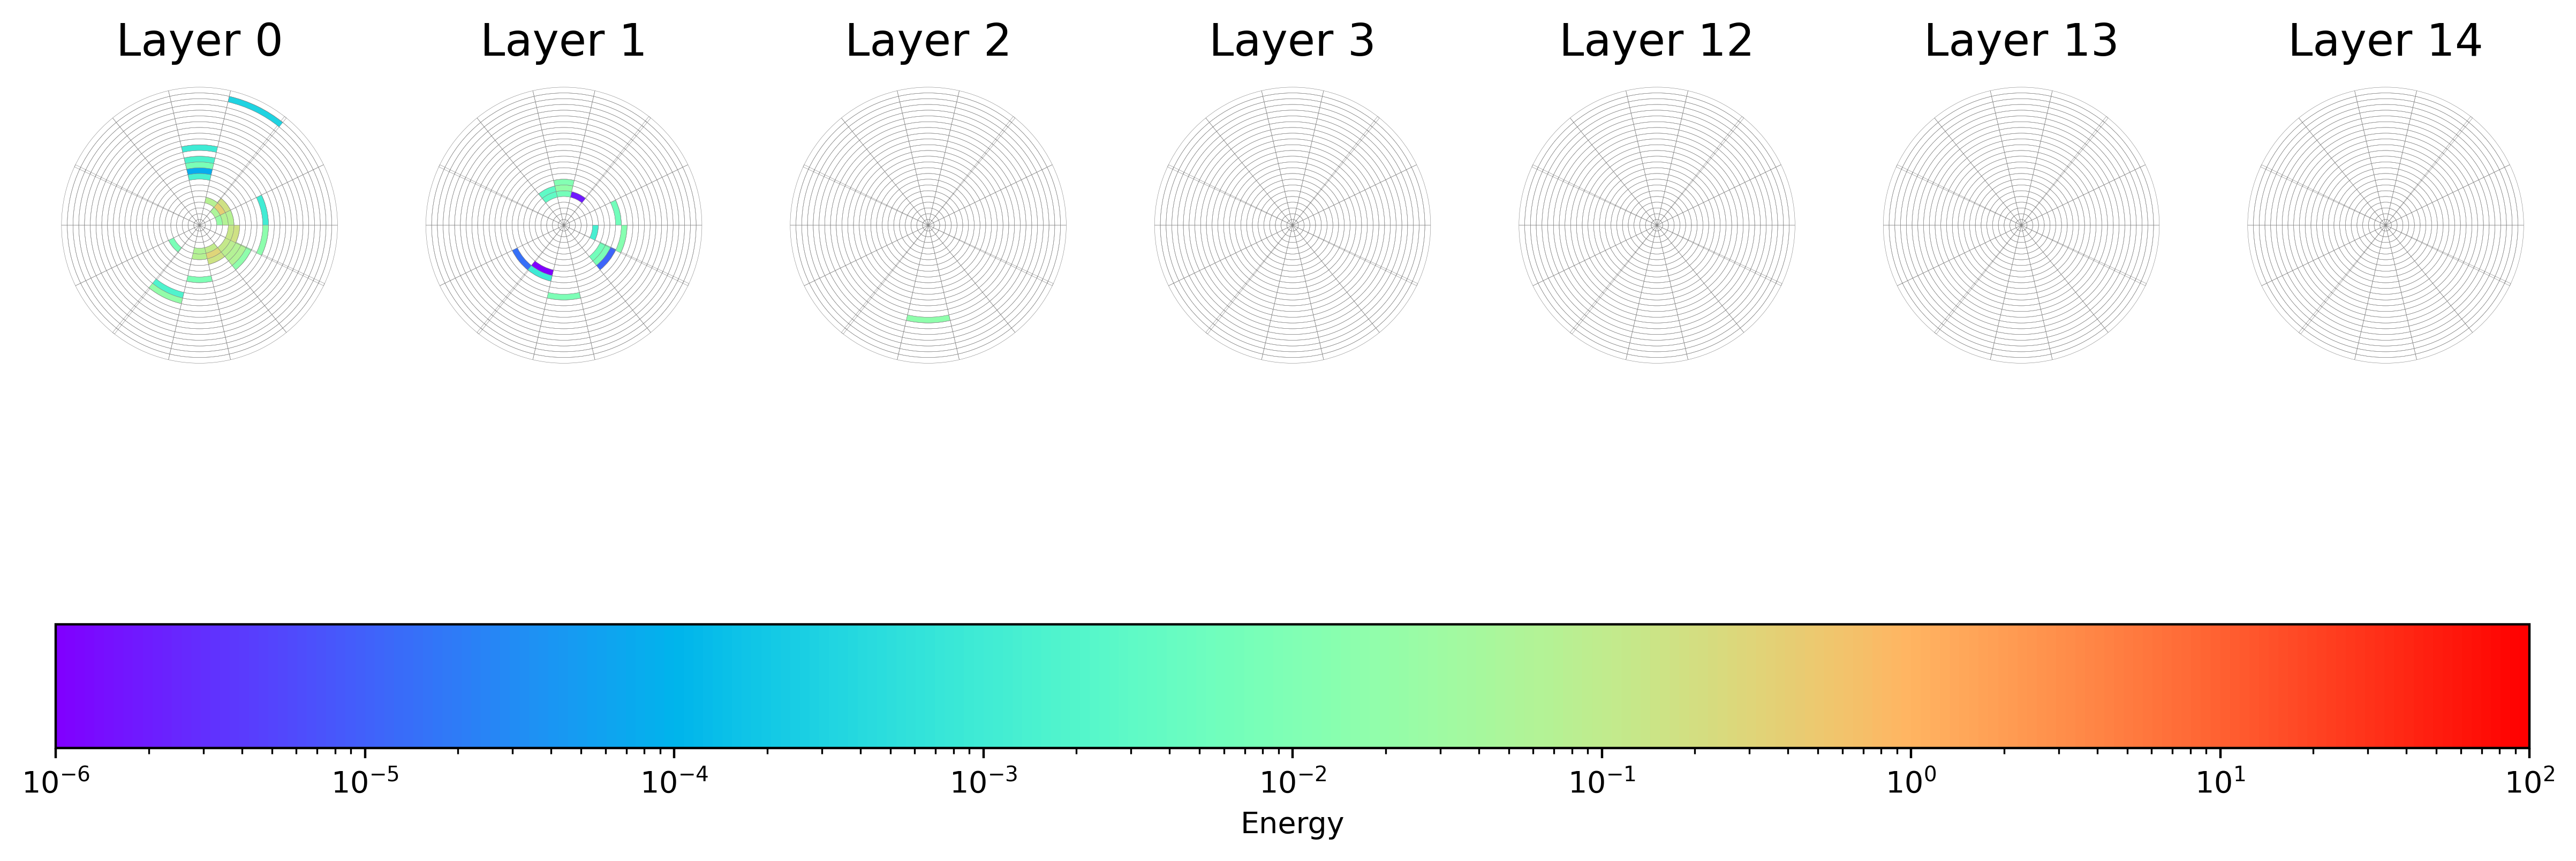

In [136]:
HLF.DrawSingleShower(events[8784,:], scale='equal_bin')

In [143]:
from utils.plotting.HighLevelFeatsAtlasReg import HighLevelFeatures_ATLAS_regular as HLF2

ModuleNotFoundError: No module named 'utils'